# 🕸 K-Nearest Neighbors Classification with Hierarchical navigable small world (HNSW)

In this notebook, we explore K-Nearest Neighbors classification with HNSW:

- **Synthetic data** generated with Gaussian noise
- Implementing a **weighted k-NN with Gaussian kernel**
  
Evaluation metrics and visualizations are included for comparison.

In [67]:
import heapq
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## 🛠️ Utils

In [68]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [69]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


def plot_clusters(
    data: NDArray[np.float64],
    centers: NDArray[np.float64],
    X_test: NDArray[np.float64],
    predicted: NDArray[np.int64],
    labels: NDArray[np.int64],
    subtitle: str = "Clustering Overview",
) -> None:
    """Plot original clusters and predictions on test data.

    Args:
        data (NDArray[np.float64]): Original dataset (n_samples, 2).
        centers (NDArray[np.float64]): Cluster centers (n_clusters, 2).
        X_test (NDArray[np.float64]): Test data points (n_test_samples, 2).
        predicted (NDArray[np.int64]): Predicted cluster labels or outputs.
        labels (NDArray[np.int64]): Ground truth labels for training data.
        subtitle (str): Title for the entire plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(subtitle)

    # Plot original data and cluster centers
    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=labels,
        alpha=0.5,
        palette="Set2",
        ax=axes[0],
    )
    axes[0].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=100,
        marker="x",
        label="Centers",
    )
    axes[0].set_title("Original Data and Cluster Centers")
    axes[0].legend()

    # Plot predictions
    axes[1].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=predicted,
        cmap="tab10",
        alpha=0.5,
    )
    axes[1].set_title("Predictions on Test Data")

    plt.tight_layout()
    plt.show()

## 📊 Generate Dataset

In [70]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=10000, num_clusters=4, space_size=50, noise_level=7, dim=2, seed=412
)

In [71]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## ⚖️ Weighted k-nearest neighbors with HNSW

In [ ]:
class Node:
    """A node in the HNSW graph.

    Attributes:
        data (NDArray[np.float64]): Feature vector of the data point.
        idx (int): Unique index of the data point in the dataset.
        level (int): Maximum level this node exists on in the graph.
        connections (dict[int, list[Node]]): Neighbors of the node for each level.
    """

    def __init__(self, point: NDArray[np.float64], idx: int, level: int) -> None:
        """Initialize a node for the HNSW graph.

        Args:
            point (NDArray[np.float64]): Feature vector of the data point.
            idx (int): Index of the data point in the dataset.
            level (int): Maximum level this node will exist on.
        """
        self.point: NDArray[np.float64] = point
        self.idx: int = idx
        self.level: int = level
        self.connections: dict[int, list["Node"]] = defaultdict(list)


class HNSWIndex:
    """HNSW index for efficient approximate nearest neighbor search.

    Attributes:
        M (int): Maximum number of connections per node.
        ef_construction (int): Size of the candidate list during graph construction.
        ef_search (int): Size of the candidate list during querying.
        max_level (int): Current highest level in the graph.
        entry_point (Node | None): Starting node for traversal during search
            and insertion.
        p (float): Order of the Minkowski distance metric.
    """

    def __init__(
        self,
        max_connections: int,
        ef_construction: int,
        ef_search: int,
        p: float = 2.0,
        seed: int | None = None,
    ) -> None:
        """Initialize an HNSW index.

        Args:
            max_connections (int): Maximum number of connections (M) per node.
            ef_construction (int): Size of the dynamic candidate list used during
                index construction.
            ef_search (int): Size of the candidate list used during querying.
            p (float, optional): Order of the Minkowski distance.
                Default is 2 (Euclidean distance).
            seed (int | None, optional): Random seed for reproducibility.
        """
        self.M: int = max_connections
        self.ef_construction: int = ef_construction
        self.ef_search: int = ef_search
        self.max_level: int = -1
        self.entry_point: Node | None = None
        self.p: float = p

        if seed is not None:
            np.random.seed(seed)

    def _generate_random_level(self, max_level: int = 16) -> int:
        """Generate a random level for a new node using an exponential distribution.

        Args:
            max_level (int): Maximum allowed level for any node.

        Returns:
            int: Assigned level for the new node.
        """
        lambda_exp = 1 / np.log(self.M)
        exp_sample = np.random.exponential(scale=1 / lambda_exp)
        level = int(exp_sample)
        return min(level, max_level)

    def _minkowski_metric(
        self, a: NDArray[np.float64], b: NDArray[np.float64]
    ) -> float:
        """Calculate Minkowski distance of order p between two points.

        Args:
            a (NDArray[np.float64]): First point.
            b (NDArray[np.float64]): Second point.
            p (float): Order of the Minkowski distance.

        Returns:
            float: Minkowski distance between points a and b.
        """
        return np.sum(np.abs(a - b) ** self.p) ** (1 / self.p)

    def _search_layer(
        self, point: NDArray[np.float64], entry_point: Node, level: int, ef_search: int
    ) -> list[tuple[float, Node]]:
        """Search for nearest neighbors of a point within a specific graph level.

        Args:
            point (NDArray[np.float64]): Query point.
            entry_point (Node): Starting node for the search.
            level (int): Level of the graph to search in.
            ef_search (int): Size of the candidate pool to maintain during search.

        Returns:
            list[tuple[float, Node]]:: List of (distance, node) tuples, sorted
                by distance.
        """
        visited: set[int] = set()
        candidates: list[tuple[float, Node]] = []
        heap: list[tuple[float, Node]] = []

        dist = self._minkowski_metric(point, entry_point.point)
        heapq.heappush(heap, (dist, entry_point))
        heapq.heappush(candidates, (-dist, entry_point))
        visited.add(entry_point.idx)

        while candidates:
            curr_dist, curr_node = heapq.heappop(candidates)
            closest_dist, _ = heap[0]

            if -curr_dist > closest_dist:
                break

            for neighbor in curr_node.connections[level]:
                if neighbor.idx in visited:
                    continue

                visited.add(neighbor.idx)
                new_dist = self._minkowski_metric(point, neighbor.point)
                heapq.heappush(heap, (new_dist, neighbor))
                heapq.heappush(candidates, (-new_dist, neighbor))

                if len(heap) > ef_search:
                    heapq.heappop(heap)

        return sorted(heap, key=lambda x: x[0])

    def _greedy_search_level(
        self, point: NDArray[np.float64], entry_point: Node, level: int
    ) -> tuple[Node, float]:
        """Perform greedy search to find the closest node on a given level.

        Args:
            point (NDArray[np.float64]): Query point.
            entry_point (Node): Starting node for the search.
            level (int): Level in which to perform the search.

        Returns:
            tuple[Node, float]: Closest node and its distance to the query point.
        """
        current_node = entry_point
        current_dist = self._minkowski_metric(point, current_node.point)

        changed = True
        while changed:
            changed = False
            for neighbor in current_node.connections.get(level, []):
                new_dist = self._minkowski_metric(point, neighbor.point)
                if new_dist < current_dist:
                    current_dist = new_dist
                    current_node = neighbor
                    changed = True

        return current_node, current_dist

    def add(self, point: NDArray[np.float64], idx: int) -> None:
        """Insert a new point into the HNSW index.

        Args:
            point (NDArray[np.float64]): Data point to insert.
            idx (int): Unique index of the data point in the dataset.
        """
        if point.shape[0] == 0:
            return

        level = self._generate_random_level()
        new_node = Node(point, idx, level)

        if self.entry_point is None:
            self.entry_point = new_node
            self.max_level = level
            return

        curr_entry = self.entry_point
        for current_level in range(self.max_level, level, -1):
            curr_entry, _ = self._greedy_search_level(point, curr_entry, current_level)

        for current_level in range(level, self.max_level + 1):
            neighbors = self._search_layer(
                point, curr_entry, current_level, self.ef_construction
            )
            selected = neighbors[: self.M]
            new_node.connections[current_level] = [node for _, node in selected]

            for _, neighbor in selected:
                neighbor.connections[current_level].append(new_node)
                if len(neighbor.connections[current_level]) <= self.M:
                    continue

                neighbor.connections[current_level] = sorted(
                    neighbor.connections[current_level],
                    key=lambda n: self._minkowski_metric(neighbor.point, n.point),
                )[: self.M]

    def search_k_nearest_neighbors(
        self, point: NDArray[np.float64], k: int
    ) -> list[tuple[float, Node]]:
        """Search for the k approximate nearest neighbors of a query point.

        Args:
            point (NDArray[np.float64]): Query point.
            k (int): Number of nearest neighbors to retrieve.

        Returns:
            list[tuple[float, Node]]: List of (distance, node) tuples for the k
                nearest neighbors.
        """
        if point.shape[0] == 0:
            return []

        curr_entry = self.entry_point
        for current_level in range(self.max_level, 0, -1):
            curr_entry, _ = self._greedy_search_level(point, curr_entry, current_level)

        neighbors = self._search_layer(point, curr_entry, 0, self.ef_search)
        return neighbors[:k]

In [81]:
def gaussian_kernel(t: NDArray[np.float64] | float) -> NDArray[np.float64] | float:
    """Gaussian (normal) kernel function.

    Args:
        t (NDArray[np.float64] | float): Input value(s).

    Returns:
        NDArray[np.float64] | float: Kernel-weighted value(s).
    """
    return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)


def weighted_knn_kernel(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    X_test: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
    h: float = 1.0,
) -> NDArray[np.float64]:
    """Predict labels using weighted k-NN with a Gaussian kernel and HNSW.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        X_test (NDArray[np.float64]): Test features, shape (n_test_samples, n_features).
        k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
        p (float, optional): Order of the Minkowski distance. Defaults to 2.0.
        h (float, optional): Bandwidth parameter for the Gaussian kernel. Defaults to 1.

    Returns:
        NDArray[np.float64]: Predicted labels for each sample in X_test.
    """
    kd_tree = HNSWIndex(
        max_connections=24, ef_construction=300, ef_search=300, p=p, seed=42
    )
    for idx, point in enumerate(tqdm(X_train, desc="Indexing")):
        kd_tree.add(point, idx)

    y_predicted: list[float] = []

    for x_new in tqdm(X_test):
        neighbors = kd_tree.search_k_nearest_neighbors(x_new, k_neighbors)

        neighbor_distances, neighbor_idx = zip(
            *[(dist, node.idx) for dist, node in neighbors], strict=False
        )
        neighbor_distances = np.array(neighbor_distances)
        neighbor_labels = y_train[np.array(neighbor_idx)]

        weights = gaussian_kernel(neighbor_distances / h)

        class_weights = {}
        for label, weight in zip(neighbor_labels, weights, strict=False):
            class_weights[label] = class_weights.get(label, 0) + weight

        predicted_label = max(class_weights, key=class_weights.get)
        y_predicted.append(predicted_label)

    return np.array(y_predicted)


# Predict labels for all samples in X_test
predicted = weighted_knn_kernel(X_train, y_train, X_test, k_neighbors=15, p=5, h=0.1)

Indexing:   0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Accuracy:  0.8666
Precision: 0.8687
Recall:    0.8666
F1 Score:  0.8657


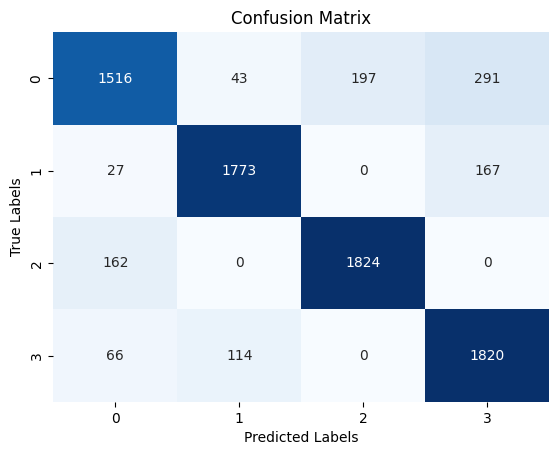

In [82]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

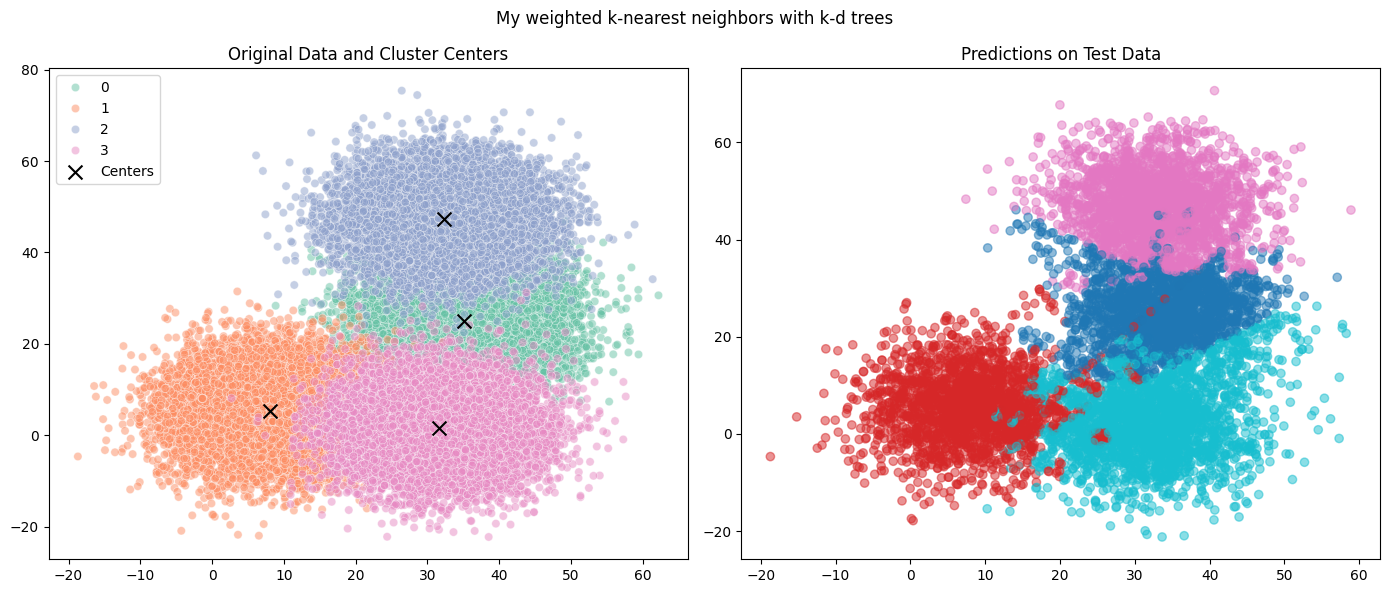

In [84]:
plot_clusters(
    data,
    centers,
    X_test,
    predicted,
    labels,
    "My weighted k-nearest neighbors with k-d trees",
)